In [1]:
import pandas as pd
import numpy as np

## read data

In [3]:
train = pd.read_csv('../DATA/hw1/train.csv', encoding='big5')
test = pd.read_csv('../DATA/hw1/test.csv',encoding='big5')

In [4]:
train.head()

,日期,測站,測項,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
0,2014/1/1,豐原,AMB_TEMP,14,14,14,13,12,12,12,...,22,22,21,19,17,16,15,15,15,15
1,2014/1/1,豐原,CH4,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
2,2014/1/1,豐原,CO,0.51,0.41,0.39,0.37,0.35,0.3,0.37,...,0.37,0.37,0.47,0.69,0.56,0.45,0.38,0.35,0.36,0.32
3,2014/1/1,豐原,NMHC,0.2,0.15,0.13,0.12,0.11,0.06,0.1,...,0.1,0.13,0.14,0.23,0.18,0.12,0.1,0.09,0.1,0.08
4,2014/1/1,豐原,NO,0.9,0.6,0.5,1.7,1.8,1.5,1.9,...,2.5,2.2,2.5,2.3,2.1,1.9,1.5,1.6,1.8,1.5


## 补0

In [8]:
data = train.iloc[:,3:]
data[data=='NR'] = 0

c:\users\zhouzy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\zhouzy\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


In [22]:
data = data.values

## 把数据处理成需要的格式

In [26]:
#把每个月的数据接到一起
month_data = []
for month in range(12):
    sample = np.empty([18, 20*24]) 
    i = 0
    for day in range(20):
        i = 18*day
        sample[:,day*24:(day+1)*24]= data[(20*month+day)*18:(20*month+day+1)*18,:]
    month_data.append(sample)

In [30]:
#把每9个小时的数据组合起来
#20*24=480h，每9个一组，有471组，一共有12个月数据，所以行数是471*12。
#有18个属性，每9个小时产生一个y。所以属性一共是18*9.
X = np.empty([471*12, 18*9])
y = np.empty([471*12, 1])
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day==19 and hour > 14:
                continue
            X[month*471+day*24+hour,:] = month_data[month][:,day*24+hour:day*24+hour+9].reshape(1,-1)
            y[month*471+day*24+hour,0] = month_data[month][9, day*24+hour+9]

## 归一化

In [33]:
# normalization
X_mean = np.mean(X, axis=0) #18*9
X_std = np.std(X, axis=0) #18*9
for i in range(len(X)): # 12*471
    for j in range(len(X[0])):#18*9
        if X_std[j] != 0:
            X[i][j] = (X[i][j] - X_mean[j]) / X_std[j]

## 划分训练集和测试集

In [39]:
import math
X_train = X[:math.floor(len(X)*0.8),:]
y_train = y[:math.floor(len(X)*0.8),:]
X_validation = X[math.floor(len(X)*0.8):, :]
y_validation = y[math.floor(len(X)*0.8):, :]

## 实现线性回归

In [ ]:
dim = 18 * 9 + 1
w = np.zeros([dim, 1])
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2))/471/12)#rmse
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight.npy', w)

In [48]:
w = np.zeros([18*9+1, 1])
learning_rate = 1e-6
iter_time = 1000


x = X
# shape is [12*471, 18*19+1]
x = np.concatenate((np.ones([12*471, 1]), x), axis=1).astype(float)

for i in range(iter_time):
    loss = np.sqrt(np.sum(np.power((y - np.dot(x,w)), 2))/(471*12)) #rmse
    if i%100==0:
        print(str(i)+':'+str(loss))
    gradient = 2 * np.dot(x.transpose(), y-np.dot(x,w))
    w = w - learning_rate * gradient
np.save('weight.npy', w)

0:27.071214829194115
100:88819576735716.1
200:7.116218239608294e+26
300:5.701509048741754e+39
400:4.568045039983691e+52
500:3.659914473331344e+65
600:2.9323209020172186e+78
700:2.3493734443965038e+91
800:1.8823163513374177e+104
900:1.5081105368594759e+117


In [66]:
import matplotlib.pyplot as plt
#plot the loss change
def plot_loss(learning_rate):
    w = np.zeros([18*9+1, 1])
    iter_time = 1000
    eps = 0.0000000001
    adagrad = np.zeros([18*9+1, 1])

    x = X
    # shape is [12*471, 18*19+1]
    x = np.concatenate((np.ones([12*471, 1]), x), axis=1).astype(float)
    loss_data = []
    for i in range(iter_time):
        loss = np.sqrt(np.sum(np.power((y - np.dot(x,w)), 2))/(471*12)) #rmse
        loss_data.append(loss)
        if i%100==0:
            print(str(i)+':'+str(loss))
        
        
        gradient = 2 * np.dot(x.transpose(), np.dot(x,w)-y)
        adagrad += gradient ** 2
        w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
    
    #plot
    plt.plot([i for i in range(iter_time)], loss_data)
    plt.show()

0:27.071214829194115
100:7.749432157387228
200:6.786315355322523
300:6.399142477533913
400:6.208572536630964
500:6.096255557223663
600:6.020609346553888
700:5.965200738221872
800:5.922492767110426
900:5.888479261608841


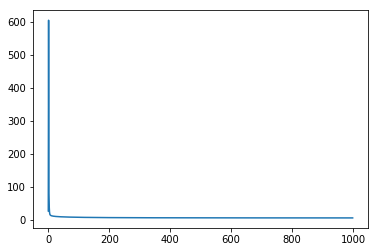

In [74]:
%matplotlib inline
plot_loss(10)

## Predicting

In [ ]:
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x

In [ ]:
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
ans_y

In [ ]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)